In [2]:
from urllib.request import urlretrieve
from zipfile import ZipFile
import pandas as pd
from dotenv import load_dotenv

load_dotenv()

url = "https://archive.ics.uci.edu/static/public/445/absenteeism+at+work.zip"

# download the file
urlretrieve(url, "Absenteeism_at_work_AAA.zip")

print("Extracting the Absenteeism at work dataset...")
# Extract the CSV file
with ZipFile("Absenteeism_at_work_AAA.zip", "r") as zf:
    zf.extractall()

# Check the extracted CSV file name (in this case, it's "Absenteeism_at_work.csv")
csv_file_name = "Absenteeism_at_work.csv"

print("Cleaning up the Absenteeism at work dataset...")
# Data clean up
df = pd.read_csv(csv_file_name, sep=";")
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace("/", "_")



Extracting the Absenteeism at work dataset...
Cleaning up the Absenteeism at work dataset...


In [3]:
import weave

weave.init("research group")

Logged in as Weights & Biases user: akash-deep.
View Weave data at https://wandb.ai/akash-deep-soais/research-group/weave


In [4]:
columns = df.columns.to_list()
columns = ", ".join(columns)
columns

'ID, Reason_for_absence, Month_of_absence, Day_of_the_week, Seasons, Transportation_expense, Distance_from_Residence_to_Work, Service_time, Age, Work_load_Average_day_, Hit_target, Disciplinary_failure, Education, Son, Social_drinker, Social_smoker, Pet, Weight, Height, Body_mass_index, Absenteeism_time_in_hours'

In [5]:
import sqlite3

connection = sqlite3.connect("absenteeism.db")
print("Opened database successfully")

connection.execute(
    """CREATE TABLE IF NOT EXISTS absenteeism (ID integer,
                        Reason_for_absence integer,
                        Month_of_absence integer,
                        Day_of_the_week integer,
                        Seasons integer,
                        Transportation_expense integer,
                        Distance_from_Residence_to_Work integer,
                        Service_time integer,
                        Age integer,
                        Work_load_Average_day_ integer,
                        Hit_target integer,
                        Disciplinary_failure integer,
                        Education integer,
                        Son integer,
                        Social_drinker integer,
                        Social_smoker integer,
                        Pet integer,
                        Weight integer,
                        Height integer,
                        Body_mass_index integer,
                        Absenteeism_time_in_hours integer);"""
)
connection.commit()

Opened database successfully


In [6]:
df.to_sql("absenteeism", connection, if_exists="replace", index=False)

740

In [7]:
connection.close()

In [8]:
from typing import List
from haystack import component


@component
class SQLQuery:

    def __init__(self, sql_database: str):
        self.connection = sqlite3.connect(sql_database, check_same_thread=False)

    @component.output_types(results=List[str], queries=List[str])
    def run(self, queries: List[str]):
        results = []
        for query in queries:
            result = pd.read_sql(query, self.connection)
            results.append(f"{result}")
        return {"results": results, "queries": queries}

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [9]:
sql_query = SQLQuery("absenteeism.db")

In [10]:
result = sql_query.run(
    queries=[
        "SELECT Age, SUM(Absenteeism_time_in_hours) as Total_Absenteeism_Hours FROM absenteeism WHERE Disciplinary_failure = 0 GROUP BY Age ORDER BY Total_Absenteeism_Hours DESC LIMIT 3;"
    ]
)
print(result['results'][0])

   Age  Total_Absenteeism_Hours
0   28                      651
1   33                      538
2   38                      482


In [12]:
import os
from getpass import getpass

# os.environ["OPENAI_API_KEY"] = getpass("OpenAI API Key: ")

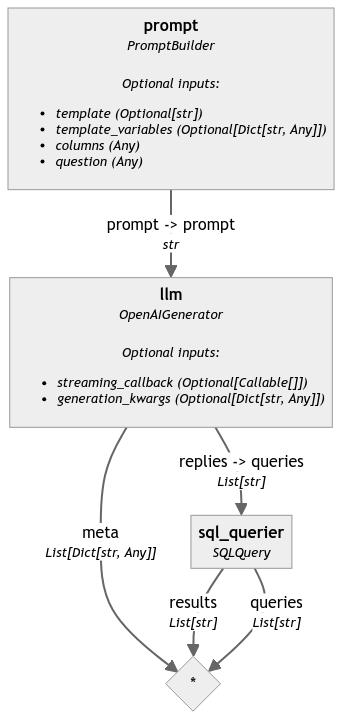

In [13]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.generators.openai import OpenAIGenerator
import re 

prompt = PromptBuilder(
    template="""Please generate an SQL query. The query should answer the following Question: {{question}};
            The query is to be answered for the table is called 'absenteeism' with the following
            Columns: {{columns}}; Only output the query and nothing else.
            Answer:"""
)
sql_query = SQLQuery("absenteeism.db")
llm = OpenAIGenerator(model="gpt-4o")

sql_pipeline = Pipeline()
sql_pipeline.add_component("prompt", prompt)
sql_pipeline.add_component("llm", llm)
sql_pipeline.add_component("sql_querier", sql_query)

sql_pipeline.connect("prompt", "llm")
sql_pipeline.connect("llm.replies", "sql_querier.queries")

# If you want to draw the pipeline, uncomment below 👇
sql_pipeline.show()

In [14]:



@weave.op()
def temp(query):
    result = result = sql_pipeline.run(
        {
            "prompt": {
                "question": "On which days of the week does the average absenteeism time exceed 4 hours?",
                "columns": columns,
            }
        }
    )
    return result["sql_querier"]["results"][0]
result = sql_pipeline.run(
    {
        "prompt": {
            "question": "On which days of the week does the average absenteeism time exceed 4 hours?",
            "columns": columns,
        }
    }
)

print(
    temp("On which days of the week does the average absenteeism time exceed 4 hours?")
)

🍩 https://wandb.ai/akash-deep-soais/research-group/r/call/0191bbe4-34d1-7273-9e4c-78a6d0b663d6


DatabaseError: Execution failed on sql '```sql
SELECT Day_of_the_week
FROM absenteeism
GROUP BY Day_of_the_week
HAVING AVG(Absenteeism_time_in_hours) > 4;
```': near "```sql
SELECT Day_of_the_week
FROM absenteeism
GROUP BY Day_of_the_week
HAVING AVG(Absenteeism_time_in_hours) > 4;
```": syntax error